# Predicting $t$ as a function of $x_t$

> Visually, it's easy to distingush between noisy and noise-less images. Beforehand, we defined $\epsilon_{\theta}^{(t)} (x_t, t)$ This module asks whether it is neccesary to pass $t$ to the model at all; can the model figure it out itself?

Adapted from

- [https://youtu.be/6Bta1tXRUfM?si=8518d0H8byMESlLt&t=943](https://youtu.be/6Bta1tXRUfM?si=8518d0H8byMESlLt&t=943)

In [1]:
#| default_exp t_pred

In [29]:
# |export
from functools import partial

import torch
import torchvision
from datasets import load_dataset
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import default_collate
from tqdm import tqdm

from slowai.augmentation import ResNetWithGlobalPoolingInitialConv, summarize
from slowai.cos_revisited import ContinuousDDPM, aesthetics, ddim, ddim_noisify, noisify
from slowai.ddpm import UNet2DModel, pipe
from slowai.ddpm import train as train_ddpm
from slowai.fid import ImageEval
from slowai.learner import (
    DataLoaders,
    DeviceCB,
    MetricsCB,
    ProgressCB,
    TrainLearner,
    after,
    batchify,
    def_device,
    fashion_mnist,
    only,
)
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_images

In [3]:
aesthetics()

We need to be empirical and understand the success conditions. We need to know if our model is good -- or if its even better than random!

Note that, to use our training loop, our torch modules need at least one trainable parameter and a trainable output.

In [4]:
class Dummy(nn.Module):
    def __init__(self):
        super().__init__()
        # We must have at least one parameter
        self._ = nn.Linear(1, 1)

    def forward(self, x_t):
        bs, *_ = x_t.shape
        # We must always output a trainable parameter
        return torch.full((bs,), 0.5, device=x_t.device, requires_grad=True)

Let's define our dataset. 

In [5]:
preprocess_ = torchvision.transforms.Compose(pipe)

In [6]:
def preprocess(examples):
    x_0 = [preprocess_(img) for img in examples["image"]]
    x_0 = torch.stack(x_0)
    ((x_t, t), _) = noisify(x_0)
    return {"x_t": x_t, "t": t.float()}

In [7]:
def get_dls(bs=512):
    dsd = load_dataset("fashion_mnist")
    dsd["train"].set_transform(preprocess)
    dsd["test"] = (
        dsd["test"]
        .map(preprocess, batched=True, remove_columns=["image", "label"])
        .with_format("torch")
    )
    return DataLoaders.from_dsd(dsd, bs=bs).listify(["x_t", "t"])

This was a bit annoying to set up, I had to learn the following:

- The best way to define a preprocessing function that works for both on-the-fly and before-the-fact is to make sure that it works with batches. This is because [`set_transform`](https://huggingface.co/docs/datasets/v2.18.0/en/package_reference/main_classes#datasets.Dataset.set_transform) operates on lists of dicts, whereas map uses only dicts of lists when `batched=True`.
- When preprocessing the test set (to keep it stable), I had to extend the `listify()` method to take a list of columns. Otherwise, it would pull the columns from the training data, which is only known after computing them on-the-fly
- When you `.map(preprocess)`, the data type is converted to arrow, which is not correctly handled by the default collator. As demonstrated, only the inner most value is converted to a tensor...

In [8]:
test = load_dataset("fashion_mnist")["test"]
ptest = test.map(preprocess, batched=True)
xb = ptest[:2]["x_t"]
cxb = default_collate(xb)
assert type(cxb) == type(cxb[0]) == type(cxb[0][0]) == list
print(f"inner most type: {type(cxb[0][0][0])}")
print(f"shape: {len(cxb), len(cxb[0]), len(cxb[0][0]), cxb[0][0][0].shape}")

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

inner most type: <class 'torch.Tensor'>
shape: (1, 32, 32, torch.Size([2]))


To fix this, we need to convert arrow to torch **before sending the batch to the collate function** by adding `.with_format("torch")` like so:

In [9]:
xb = ptest.with_format("torch")[:2]["x_t"]
xb.shape

torch.Size([2, 1, 32, 32])

This is what it looks like:

In [10]:
%%time
dls = get_dls()

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

CPU times: user 2.23 s, sys: 229 ms, total: 2.46 s
Wall time: 2.73 s


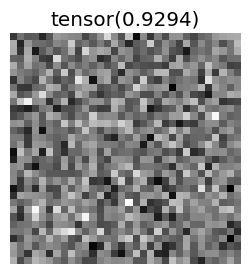

In [11]:
r = dls.splits["test"][96]
xt, t = r["x_t"], r["t"]
show_images(xt, titles=[t])

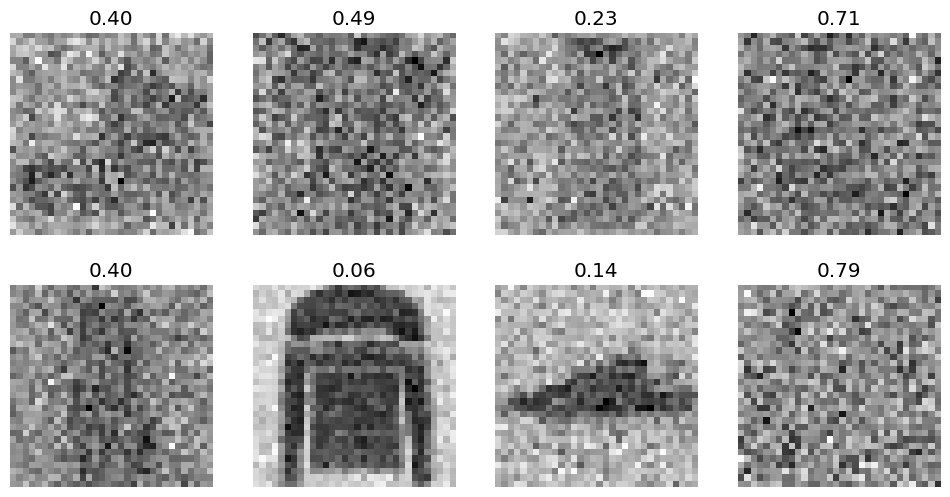

In [12]:
(xb, t) = dls.peek()
n = 8
show_images(
    xb[:n].squeeze(),
    titles=[f"{tt.item():.2f}" for tt in t[:n]],
)

Now, we can train the dummy model.

In [13]:
def train(model, dls, n_epochs=20, lr=1e-2, log_periodicity=10, extra_cbs=None):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        DeviceCB(),
        MetricsCB(),
        ProgressCB(plot=True, periodicity=log_periodicity),
        scheduler,
    ]
    if extra_cbs:
        cbs.extend(extra_cbs)
    learner = TrainLearner(model, dls, cbs=cbs)
    learner.fit(n_epochs=n_epochs)

loss,epoch,train
0.083,0,train
0.083,0,eval
0.083,1,train
0.083,1,eval
0.083,2,train
0.083,2,eval


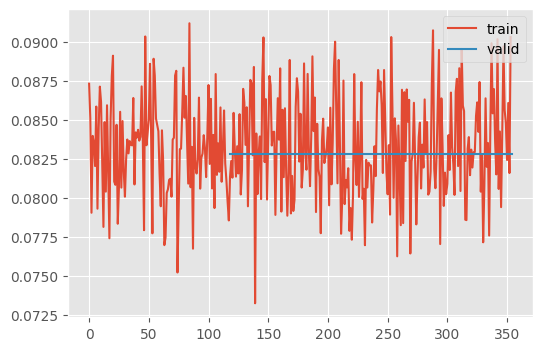

CPU times: user 3.94 s, sys: 1.82 s, total: 5.76 s
Wall time: 11 s


In [14]:
%%time
train(Dummy(), dls, n_epochs=3)

Notice that loss does not change during the second epoch. (It does change a tiny bit, for whatever reason.) This is our baseline. Anything worse than this is totally useless.

We can use the same model for classification from before, just changing the number of outputs and flattening it.

In [15]:
class RegressionResNet(ResNetWithGlobalPoolingInitialConv):
    def __init__(self, nfs=[16, 32, 64, 128, 256, 512]):
        return super().__init__(nfs, 1)

    def forward(self, x):
        x = super().forward(x)
        assert x.shape[-1] == 1
        return x.squeeze()

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| ResidualConvBlock | (8, 16, 28, 28) | (8, 32, 14, 14) | 14,496 | 2.8
| ResidualConvBlock | (8, 32, 14, 14) | (8, 64, 7, 7) | 57,664 | 2.8
| ResidualConvBlock | (8, 64, 7, 7) | (8, 128, 4, 4) | 230,016 | 3.7
| ResidualConvBlock | (8, 128, 4, 4) | (8, 256, 2, 2) | 918,784 | 3.7
| ResidualConvBlock | (8, 256, 2, 2) | (8, 512, 1, 1) | 3,672,576 | 3.7
| Linear | (8, 512) | (8, 1) | 513 | 0.0
| Total | | | 4,894,049 | |

loss,epoch,train
0.203,0,train
0.003,0,eval
0.003,1,train
0.003,1,eval
0.003,2,train
0.002,2,eval
0.003,3,train
0.002,3,eval
0.003,4,train
0.002,4,eval


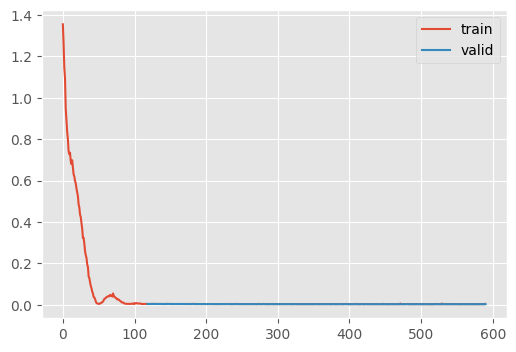

CPU times: user 16.1 s, sys: 6.03 s, total: 22.1 s
Wall time: 27.6 s


In [19]:
%%time
t_predictor = RegressionResNet.kaiming()
summarize(t_predictor, "ResidualConvBlock|Linear")
train(t_predictor, dls, n_epochs=5)

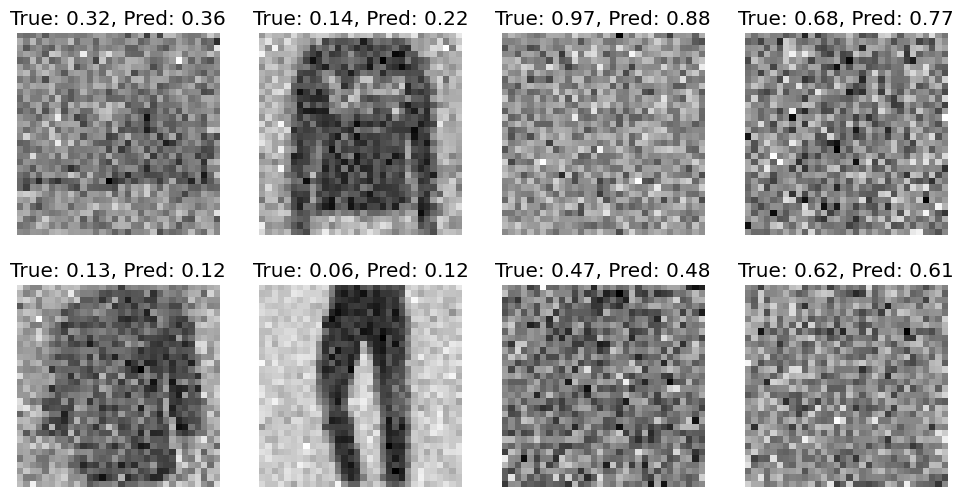

In [20]:
(xb, t) = dls.peek(split="test")
xb, t = xb[:8, ...], t[:8, ...]
t_pred = t_predictor(xb.to(def_device))
titles = [f"True: {tt.item():.2f}, Pred: {tp.item():.2f}" for tt, tp in zip(t, t_pred)]
show_images(xb.squeeze(), titles=titles)

This is worse than what Jeremy reports, but he was using a training batch without augmentation, so he was likely learning the training data directly. Note that Jeremy uses a batch of training data and that our discrepancy is in-line with what we're getting in the evaluation (unlike Jeremy's, where the discrepancy is quite large at $\approx\sqrt{0.08}$.) 

In [21]:
with torch.no_grad():
    mse = torch.nn.functional.mse_loss(t_pred.to(def_device), t.to(def_device))
mse

tensor(0.0037, device='cuda:0')

Nice to know that I'm at the point where I can spot bugs in Jeremy's code 🐛

In [22]:
eval = ImageEval.fashion_mnist(bs=256)

## Applying $t$-predictor to the diffusion model

At this point, we can add the $t$ predicting model to the diffusion process.

In [23]:
class ContinuousDDPMWithTPred(ContinuousDDPM):
    @only
    def predict(self, learn):
        (x_t, t), _ = learn.batch
        with torch.no_grad():
            t = t_predictor(x_t).clip(0.01, 0.99)
        learn.preds = learn.model(x_t, t).sample

loss,epoch,train
0.212,0,train
0.085,0,eval
0.064,1,train
0.054,1,eval
0.047,2,train
0.044,2,eval
0.042,3,train
0.042,3,eval
0.040,4,train
0.039,4,eval


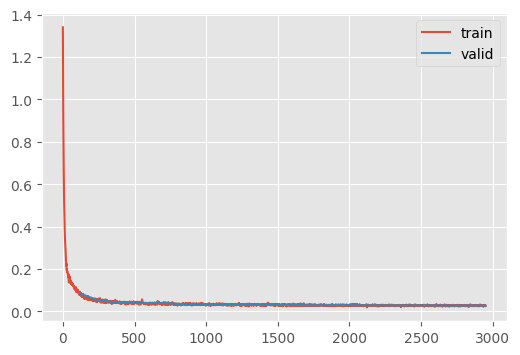

CPU times: user 10min 1s, sys: 3min 49s, total: 13min 50s
Wall time: 11min 29s


In [30]:
%%time
unet = UNet2DModel(
    sample_size=(32, 32),
    in_channels=1,
    out_channels=1,
    block_out_channels=(16, 32, 64, 128),
    norm_num_groups=8,
)
ddpm = ContinuousDDPMWithTPred(βmax=0.01)
train_ddpm(
    unet,
    lr=1e-2,
    n_epochs=25,
    opt_func=partial(torch.optim.Adam, eps=1e-5),
    ddpm=ddpm,
    bs=512,
)

In [39]:
# |export
@torch.no_grad()
def ddim_t_pred(
    model,
    sz=(16, 1, 32, 32),
    device=def_device,
    n_steps=100,
    eta=1.0,
    noisify=ddim_noisify,
):
    x_t = torch.randn(sz, device=device)
    ts = torch.linspace(1 - (1 / n_steps), 0, n_steps).to(device)
    for _, t_next in tqdm(zip(ts, ts[1:]), unit="time step", total=n_steps - 1):
        # Find $t$ from $x_t$
        t = t_predictor(x_t).clip(0.01, 0.99)

        # Predict the noise for each example in the image
        noise_pred = model(x_t, t).sample

        # Predict the image without noise
        x_0_pred = denoisify(x_t, noise_pred, t)

        # Renoise, if needed
        prev_sample = noisify(eta, x_0_pred, noise_pred, t, t_next)

        # Repeat
        x_t = prev_sample

    x_0 = denoisify(x_t, noise_pred, t)

    return x_0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 31.74time step/s]


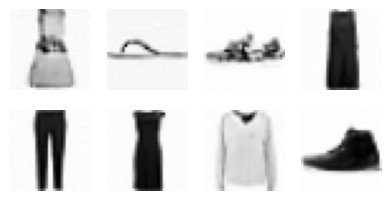

In [44]:
x_0 = ddim(unet, sz=(256, 1, 32, 32))
show_images(x_0[:8, ...].squeeze(), imsize=1.2)

In [45]:
x_0.min(), x_0.max()

(tensor(-0.5532, device='cuda:0'), tensor(0.6188, device='cuda:0'))

In [46]:
eval.fid(x_0)

147.68310546875

Compare to `789.25` without predicting $t$ (and `158.81` for a real batch). So, the metrics are much better but it doesn't look better?

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()